# Pattern Extraction Tool 

In this notebook we are going to showcase a tool we have developed that aims to extract interesting patterns from a labeled time series. Specifically, the goal is to detect patterns that are likely characteristic of the behaviour of the time series in labeled regions. 

For the scope of this demonstration notebook, we use time series data from wind turbines that are provided by [ENGIE](https://www.laborelec.com/). With the utilization of the data along with sparse labels that were available, we tried to detect patterns that could signify a specific behaviour, more specifically the yaw alignment or misalignment of a wind turbine. The notebook will focus on this specific dataset, however the methods are not restricted to wind turbines and can be easily used in other problems that can be formulated in a similar manner. 

## Loading the modules that will be used throughout the notebook

In [1]:
import sys, os
paths = ['', '..', '../..']
for p in paths:
    if p not in sys.path:
        sys.path.insert(0, p)
import h5py
import matrixprofile as mpf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
from matrixprofile.visualize import visualize_md
from matrixprofile import core
from ast import literal_eval
from sklearn.preprocessing import MinMaxScaler
from modules.io import *
from modules.patterns import *
from modules.plots import *
from modules.preprocessing import *
from modules.similarity import *
from numba import cuda, njit, set_num_threads
import timeit
set_num_threads(32)
%matplotlib inline

## Loading and preprocessing the dataset
Initially, we are going to load the dataset and then perform some preprocessing steps. We are going to scale each column of the dataset to the \[0, 1\] interval, then we are going to change the granularity of the measurements from two seconds to thirty and add really small amount of noise in order to prevent constant regions in our time series, as that causes problems with the matrix profile algorithm which uses the z-normalized euclidean distance. Then we are going to filter out some dates and keep a small subset of the dataset for demonstration purposes.


In [2]:
dataset_file = '/data/data2/engie_initial/post_treated_data/BEZ/BEBEZE02_scada_high_frequency.parquet'
df = load_df(dataset_file)
df.head()

,wind speed,pitch angle,rotor speed,active power,cos_nacelle_dir,sin_nacelle_dir,cos_wind_dir,sin_wind_dir,nacelle direction,wind direction
datetime,,,,,,,,,,
2018-01-03 00:00:00,11.272275,3.650000,15.220119,1936.342041,-0.999998,-0.002026,-0.996706,0.081106,180.116089,175.347885
2018-01-03 00:00:02,10.005727,3.886307,15.229703,1992.992554,-0.999998,-0.002026,-0.993781,-0.004818,180.116089,186.393020
2018-01-03 00:00:04,10.507183,4.122613,15.239287,2022.112915,-0.999998,-0.002026,-0.991553,-0.129418,180.116089,187.452170
2018-01-03 00:00:06,10.704224,4.358920,15.248871,2027.170776,-0.999998,-0.002026,-0.988565,-0.150475,180.116089,188.673038
2018-01-03 00:00:08,10.312802,4.595226,15.258455,2015.790172,-0.999998,-0.002026,-0.985330,-0.170225,180.116089,189.826151


In [3]:
# pick some specific columns
cols = ['wind speed', 'active power', 'rotor speed', 'pitch angle', 'sin_wind_dir', 'sin_nacelle_dir', 'cos_wind_dir', 'cos_nacelle_dir']
df = df[cols]
# Scale each column to 0-1
df = scale_df(df)

# Resample with a 60sec granularity
granularity = '60s'
df = change_granularity(df, granularity, chunk=False)

# add small noise to series
df = add_noise_to_series_md(df, noise_max = 0.00009)

# Keep only one month before and after the fringe measurements
start = '2018-07-02'
end = '2019-01-11'
df = filter_dates(df, start, end)
print(df.shape)

(277921, 8)


## Computing the multi-dimensional matrix profile
With the assistance of the [STUMPY](https://github.com/TDAmeritrade/stumpy) Python library, we are going to compute the multi dimensional matrix profile (will be also denoted as MP) on our dataset. The MP algorithm allows for constrained multi-dimensional motif search, so we pick dimensions that must be included, i.e 'active power', in this demonstration. After computing the MP we save it along with the index that accompanies it as an hdf5 file.

In [4]:
m = 60 * 24 # window size or length of the patterns we are looking for

# pick the dimensions that must be included in the multi-dimensional mp 
include = ['active power']
col_indexes = []
for n in include:
    col_indexes.append(df.columns.get_loc(n))

# calculate the multi-dimensional MP here
start_time = timeit.default_timer()
mps, indices = mstump(df, m, include = col_indexes)
end_time = timeit.default_timer()
mp_len = mps.shape[0]
print(end_time - start_time)
# save the MP and index
output_dir = './test_mp/'
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True) 
output_name = 'test'
save_mdmp_as_h5(output_dir, output_name, mps, indices)

print("Finished")

5971.177144432906
Finished


When dealing with a multi-dimensional MP one must pick the k most relevant dimensions, as the addition of extra irrelevant dimensions can degrade the perfonrmance of the algorithm significantly. That problem as well as a way to combat it, is described in the paper [Matrix Profile VI: Meaningful Multidimensional Motif Discovery](https://www.cs.ucr.edu/~eamonn/Motif_Discovery_ICDM.pdf), that way is the usage of the "knee" or "elbow" method. According to this method, we plot the minimum value of the MP for each value k of dimensions and find the "turning point". By doing this in our data (as seen in the cell below), we observe that after the value k = 6 the values start to dramatically increase suggesting that the "natural" dimensionality of patterns in our data is for k = 6 number of dimensions. (Since k is 0-idnexed this means 7 dimensions)    

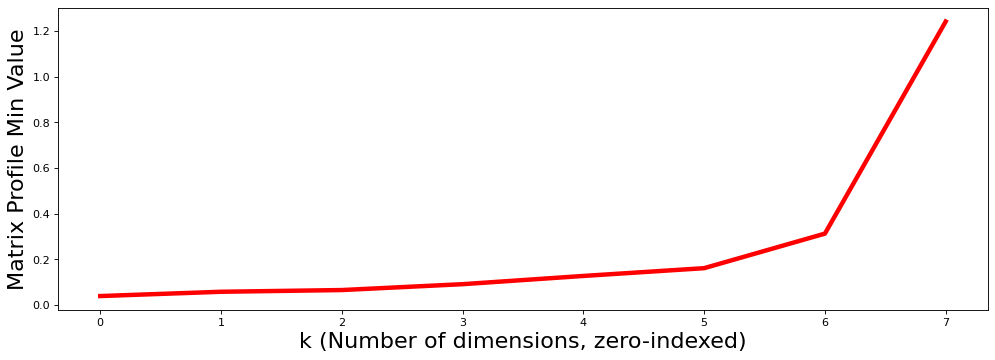

In [5]:
plot_knee(mps)

Afterwards, by specifying the number of the dimensions and any dimension we explicitly want to include ("active power" in this specific case) we get the subspace of dimensions in which the k-dimensional matrix profile was computed. 

In [6]:
k = 6
include = ['active power']
picked_cols =  pick_subspace_columns(df, mps, indices, k, m, include)
df = df[picked_cols]
df.head()

Include dimensions: ['active power'], indexes in df = [1]
For k = 6, the 7-dimensional subspace includes subsequences from ['active power' 'cos_wind_dir' 'cos_nacelle_dir' 'sin_wind_dir'
 'sin_nacelle_dir' 'rotor speed' 'wind speed']


,active power,cos_wind_dir,cos_nacelle_dir,sin_wind_dir,sin_nacelle_dir,rotor speed,wind speed
datetime,,,,,,,
2018-07-02 00:00:00,0.251315,0.797444,0.831928,0.900215,0.873991,0.630326,0.209350
2018-07-02 00:01:00,0.261839,0.793321,0.831963,0.903723,0.873955,0.632728,0.212541
2018-07-02 00:02:00,0.254280,0.798562,0.831972,0.897928,0.874007,0.626864,0.213613
2018-07-02 00:03:00,0.278444,0.787157,0.831984,0.907024,0.873997,0.633154,0.223742
2018-07-02 00:04:00,0.267607,0.799560,0.831937,0.897544,0.874028,0.635454,0.218694


## Using the annotation vector functionality
At this place, we load the k-dimensional MP that we have saved earlier and we apply our multi-dimensional extension of the ["complexity" annotation vector](https://matrixprofile.docs.matrixprofile.org/_modules/matrixprofile/transform.html#make_complexity_av) by the Matrix Profile Foundation library. We do this in order to penalize constant or almost constant regions of the time-series that have too low complexity to contain any "meaningful" pattern.

In [7]:
mp, index = load_mdmp_from_h5(output_dir, output_name, k)
profile = compute_mp_av(mp, index, m, df, k)
output_name = output_name + '_av'
save_mdmp_as_h5(output_dir, output_name, profile['cmp'], profile['pi'], k)

Making multi-dim av...


## Interesting Pattern Extraction (Top-k motifs)
Using the corrected matrix profile (a matrix profile after we apply the annotation vector, CMP) that we saved in the previous cell, we are now going to try to find some "meaningful" patterns. Utilizing our multi-dimensional extension of the [top k motifs](https://github.com/matrix-profile-foundation/matrixprofile/blob/master/matrixprofile/algorithms/top_k_motifs.py) algorithm from Matrix Profile Foundation, we are searching for the top-k motifs and their neighbors in our dataset. For each one of the top-k motif pair we calculate a cost based on the distribution of the pair along with its neighbors on labeled regions of the time series. For example, in this specific case we look for patterns that along with the majority of their neighbors will fall into an "aligned" or "misaligned" region that we have defined, that signifies the yaw alignment or misalignment of a wind turbine. The intuition behind this, is that if a pattern as well as the majority of its neighbors, lie in a region of a specific label then that pattern is likely to be a "meaningful" characteristic of the region.

We perform the aforementioned serach for top-k motifs with multiple settings (different exclusion zones and search radii). We can save visual as well as statistial results for each setting as well as a summary that contains statistical results for all the experimental settings.

Note: The majority and the cost are calculated on normalized values of the occurances ("aligned"/"misaligned" in this case) based on the lengths of the segments.

In [8]:
mp, index = load_mdmp_from_h5(output_dir, output_name, k)
ezones = [0.125, 0.25, 0.5, 2, 4, 8]
radii = [1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
segment_labels = ['aligned', 'misaligned']
output_list_full = []
m1 = (df.index >= '2018-10-17') & (df.index < '2018-10-24')
m2 = (df.index >= '2018-12-11')
mask = np.logical_or.reduce([m1, m2])
results_dir = 'results_test'
pathlib.Path(results_dir).mkdir(parents=True, exist_ok=True) 
for radius in radii:
    for ez in ezones:
        topk = 10
        max_neighbors = 100
        profile = get_top_k_motifs(df, mp, index, m, ez, radius, k=topk, max_neighbors=max_neighbors)
        output_list = calculate_motif_stats(profile, mask, topk, m, ez, radius, segment_labels)
        sub_dir_name = 'results' + str(m) + '_' + str(ez) + '_' + str(radius)
        output_list_full.extend(output_list)
        
        # the following line can be uncommented to save results for each setting separately
        #save_results(results_dir, sub_dir_name, profile, df_output, m, radius, ez, topk, max_neighbors)
summary_name = './summarized_results_test.csv'
df_output = pd.DataFrame(output_list_full, columns=['k', 'motif_subseq_1', 'motif_subseq_2', 'aligned',
                                               'misaligned', 'cost', 'window_size', 'exclusion_zone',
                                               'radius', 'motif indices', 'majority of motif instance occurences'])
df_output.to_csv(summary_name, index=False)

## Visualization example

Here we are going to showcase an example visual demonstration of the patterns found as well as their neighbors for one specific setting. This visualization is based on the [visualize](https://github.com/matrix-profile-foundation/matrixprofile/blob/master/matrixprofile/visualize.py) function from Matrix Profile Library, modified for multi-dimensional time series.

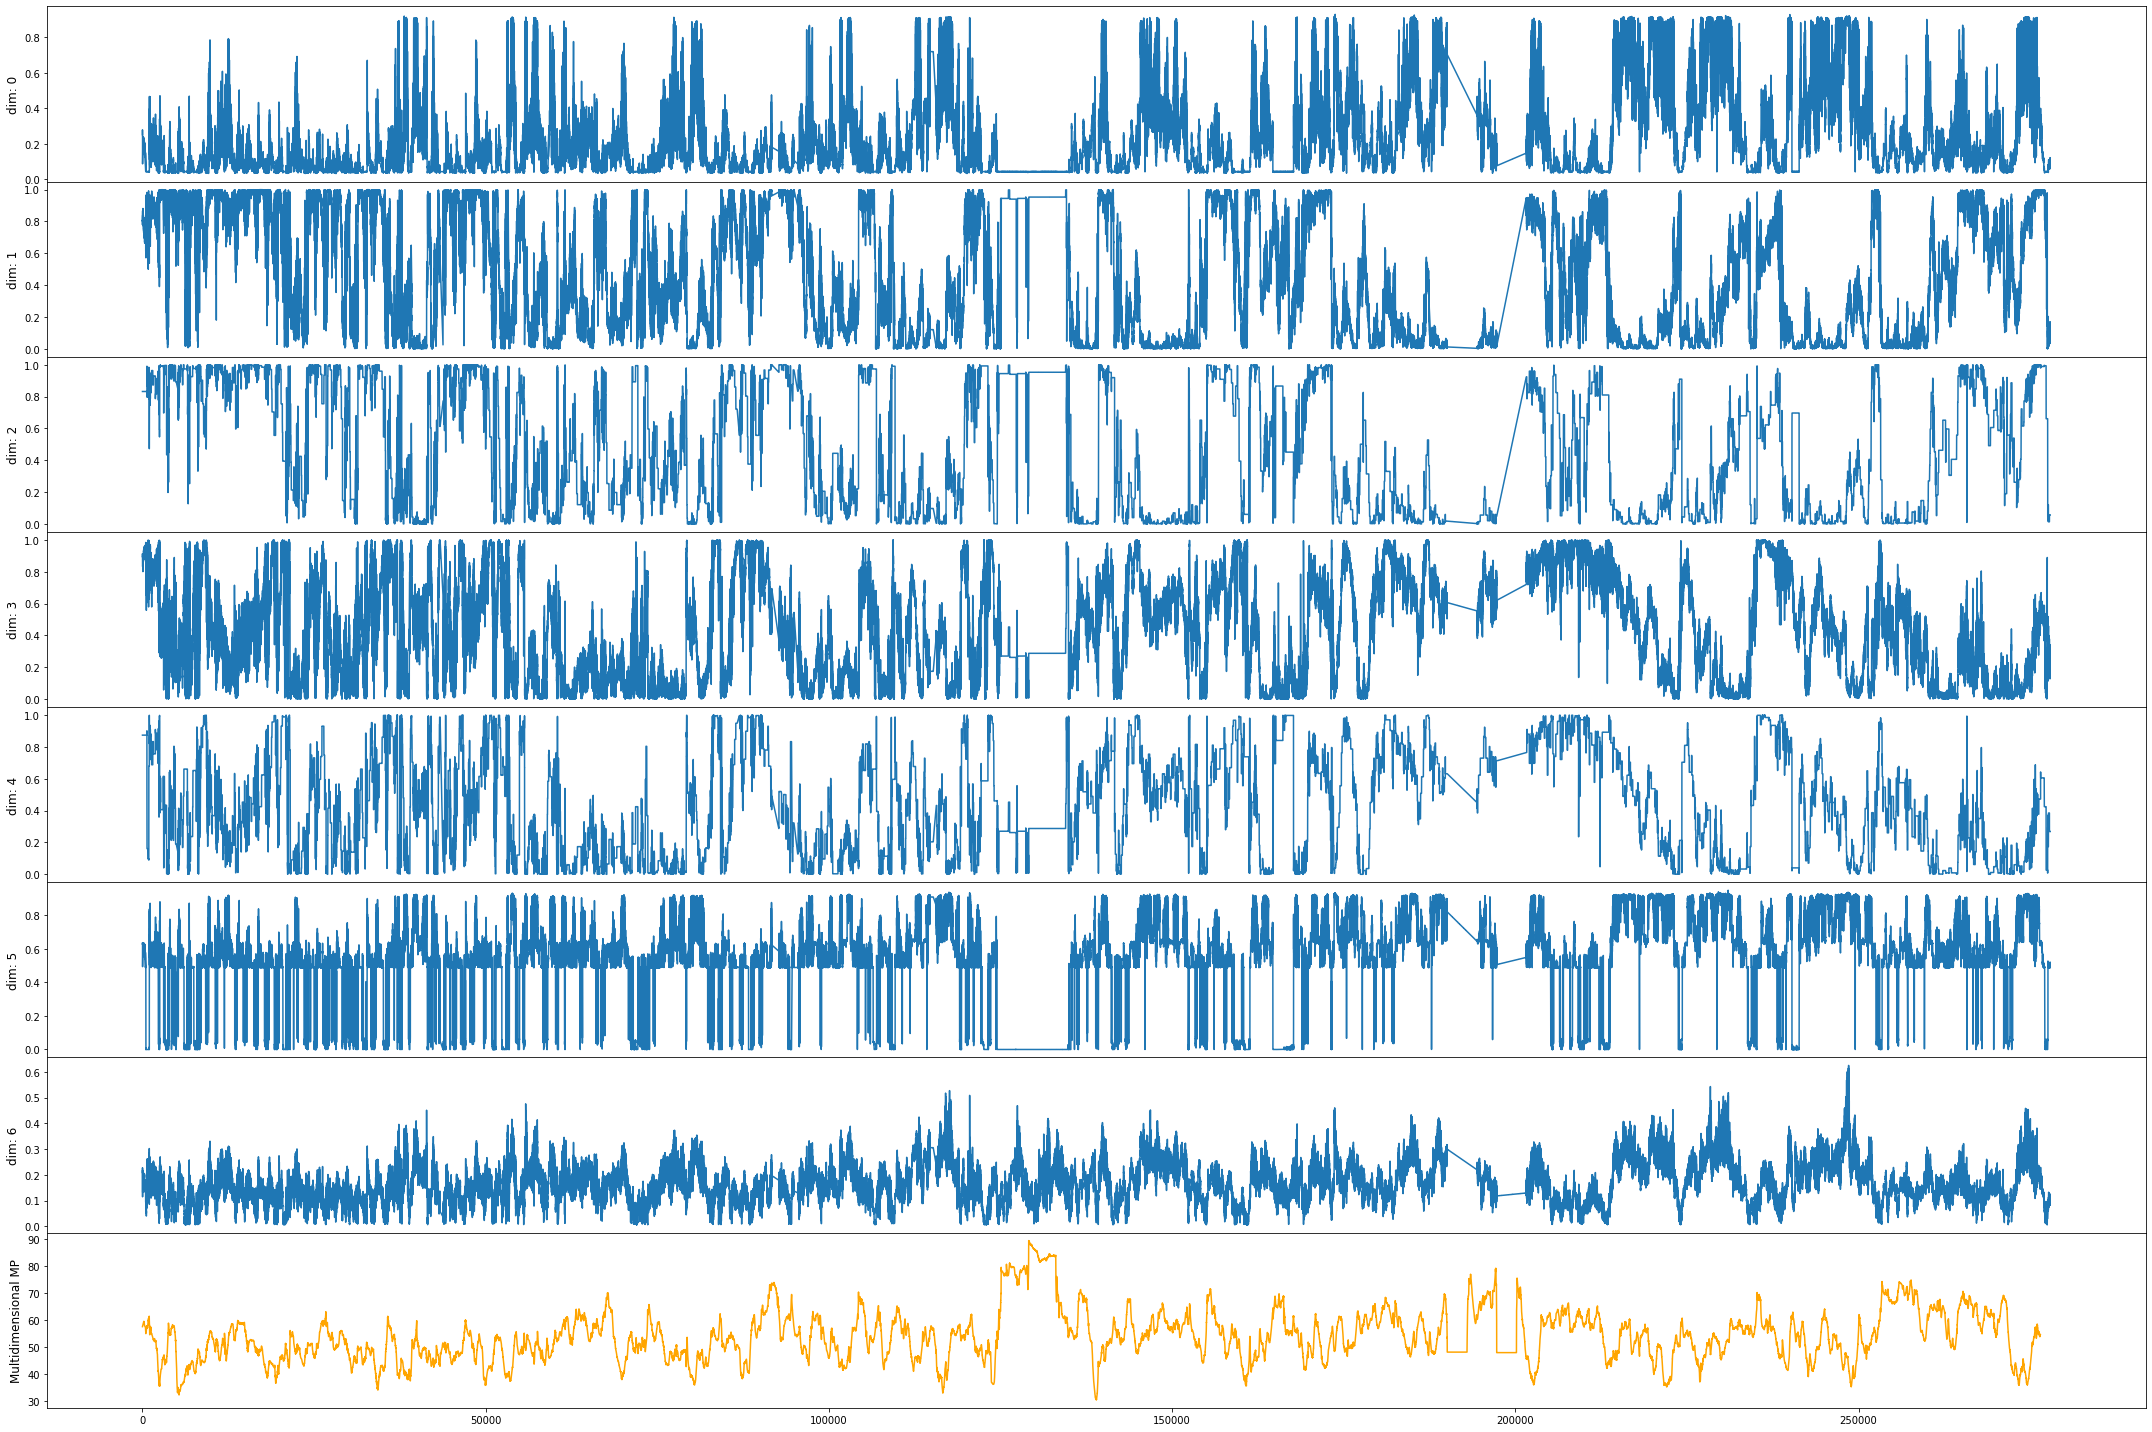

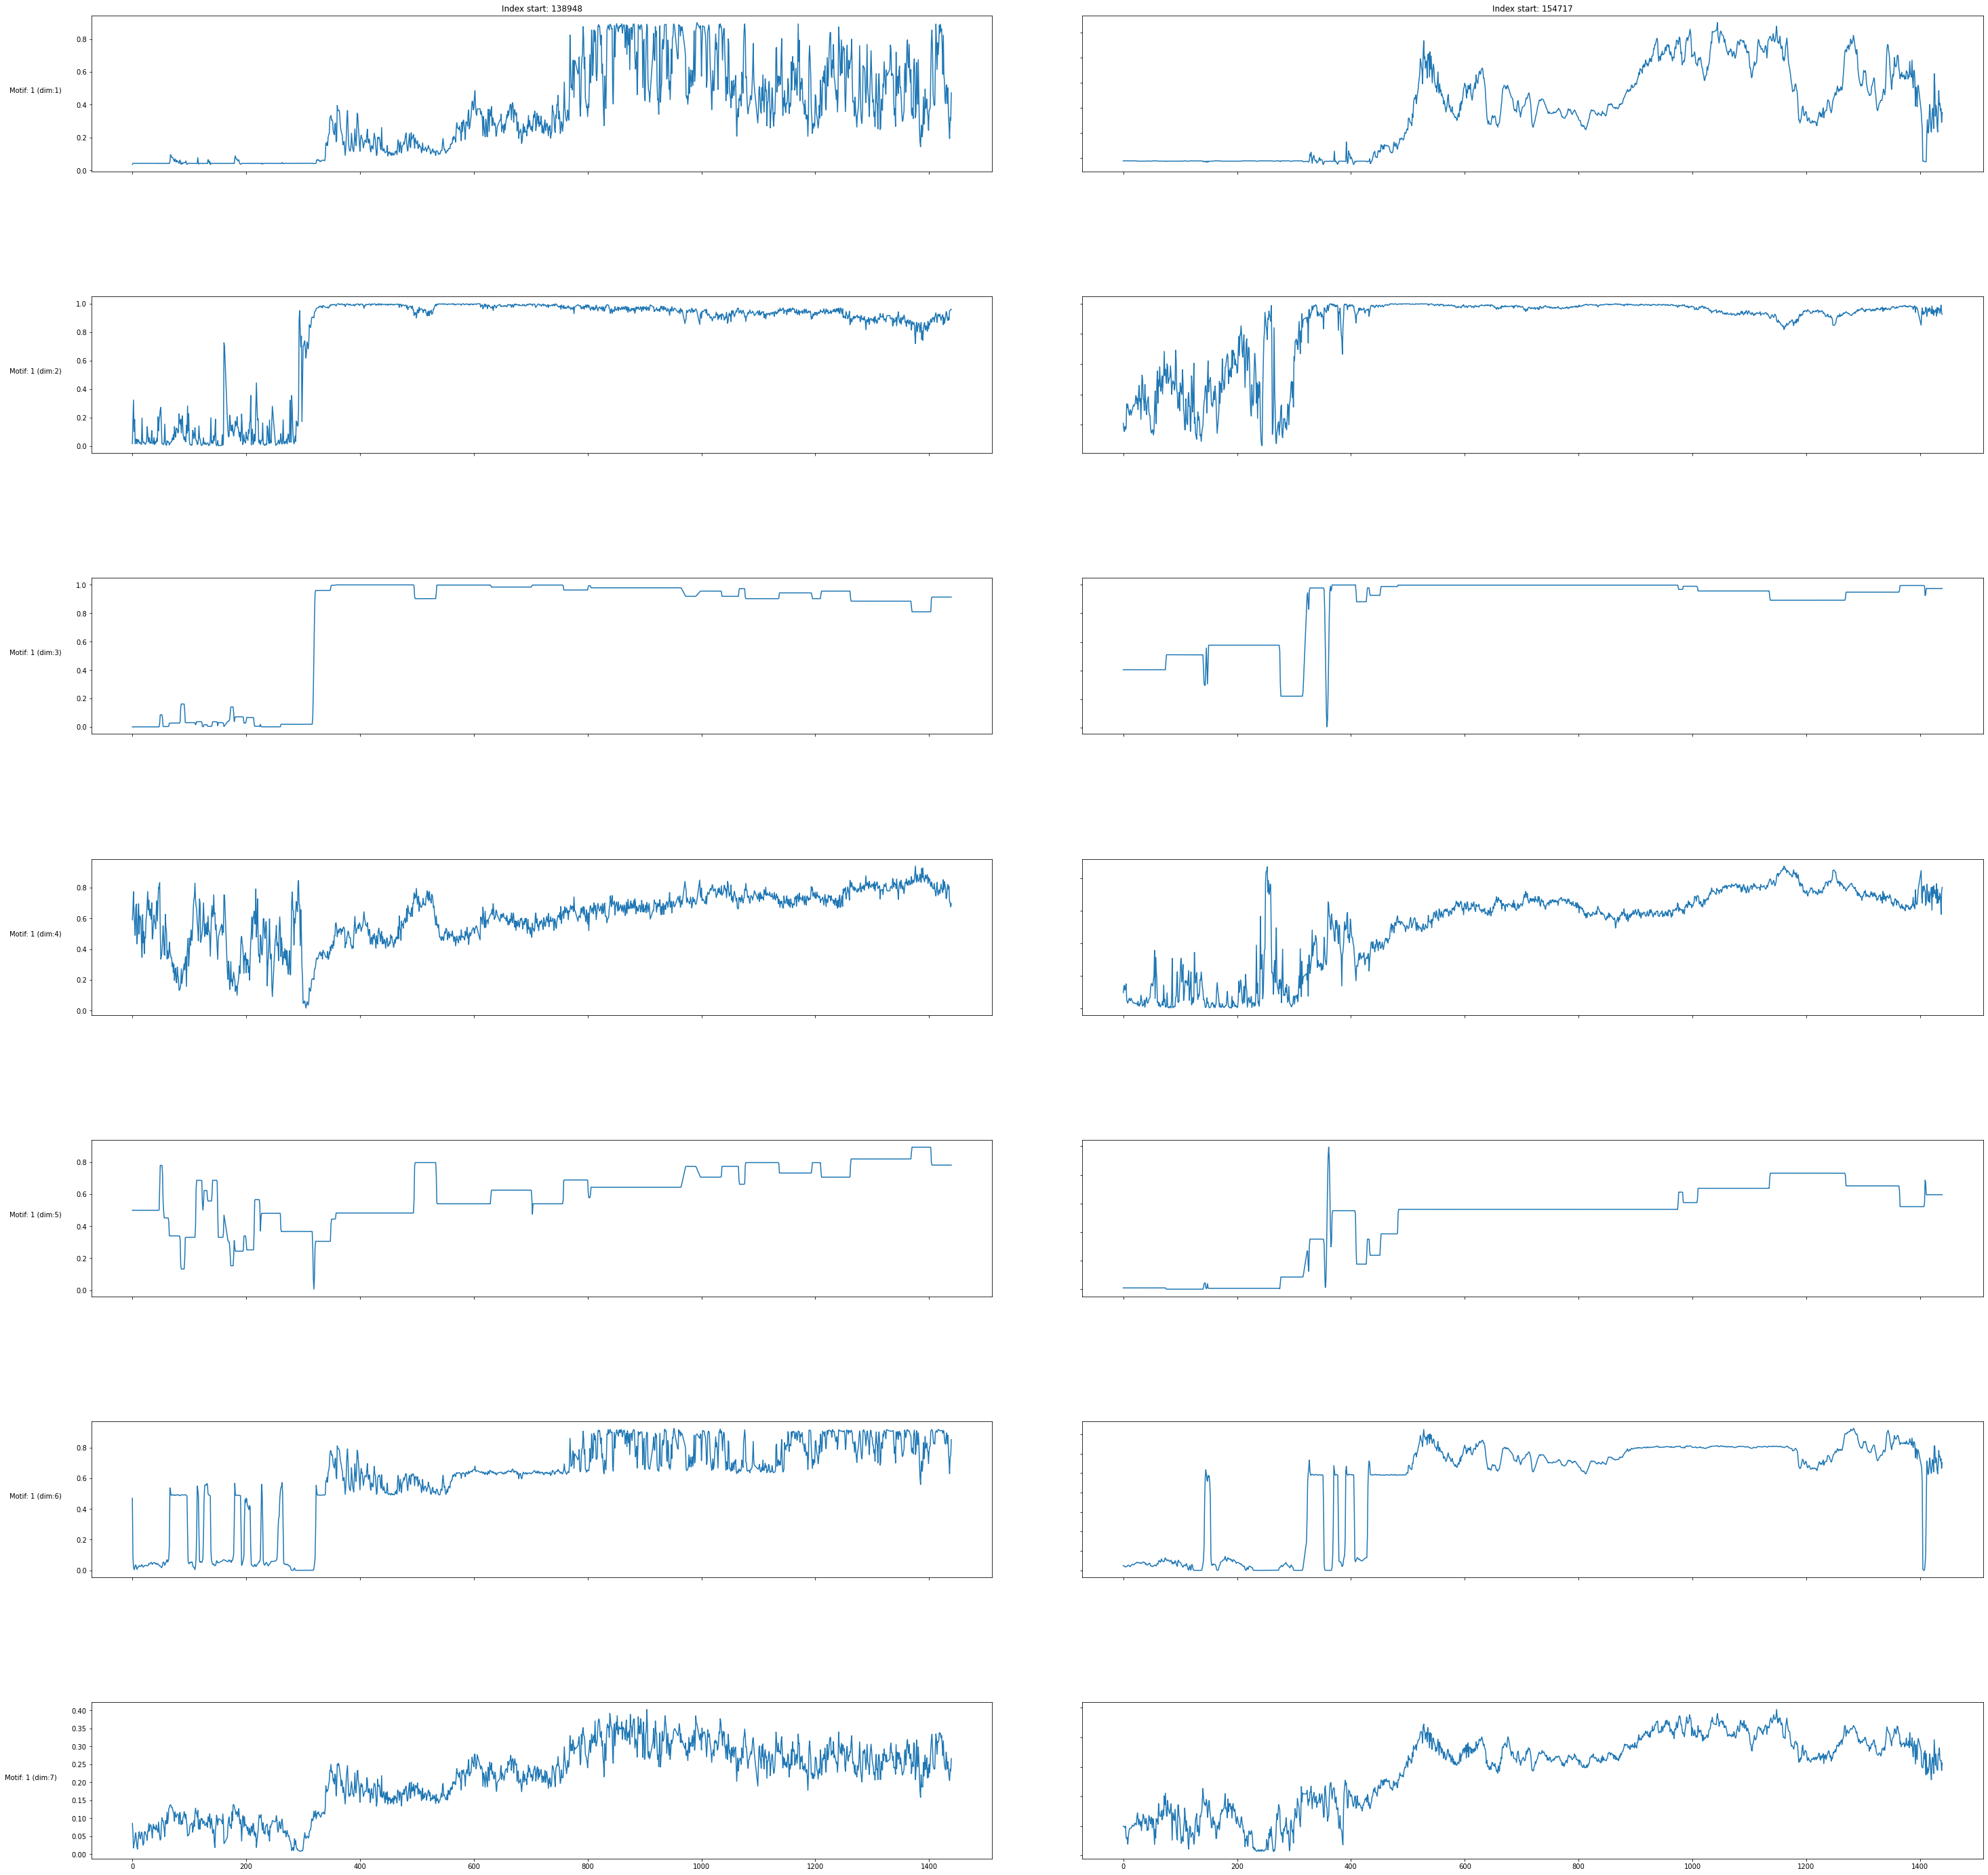

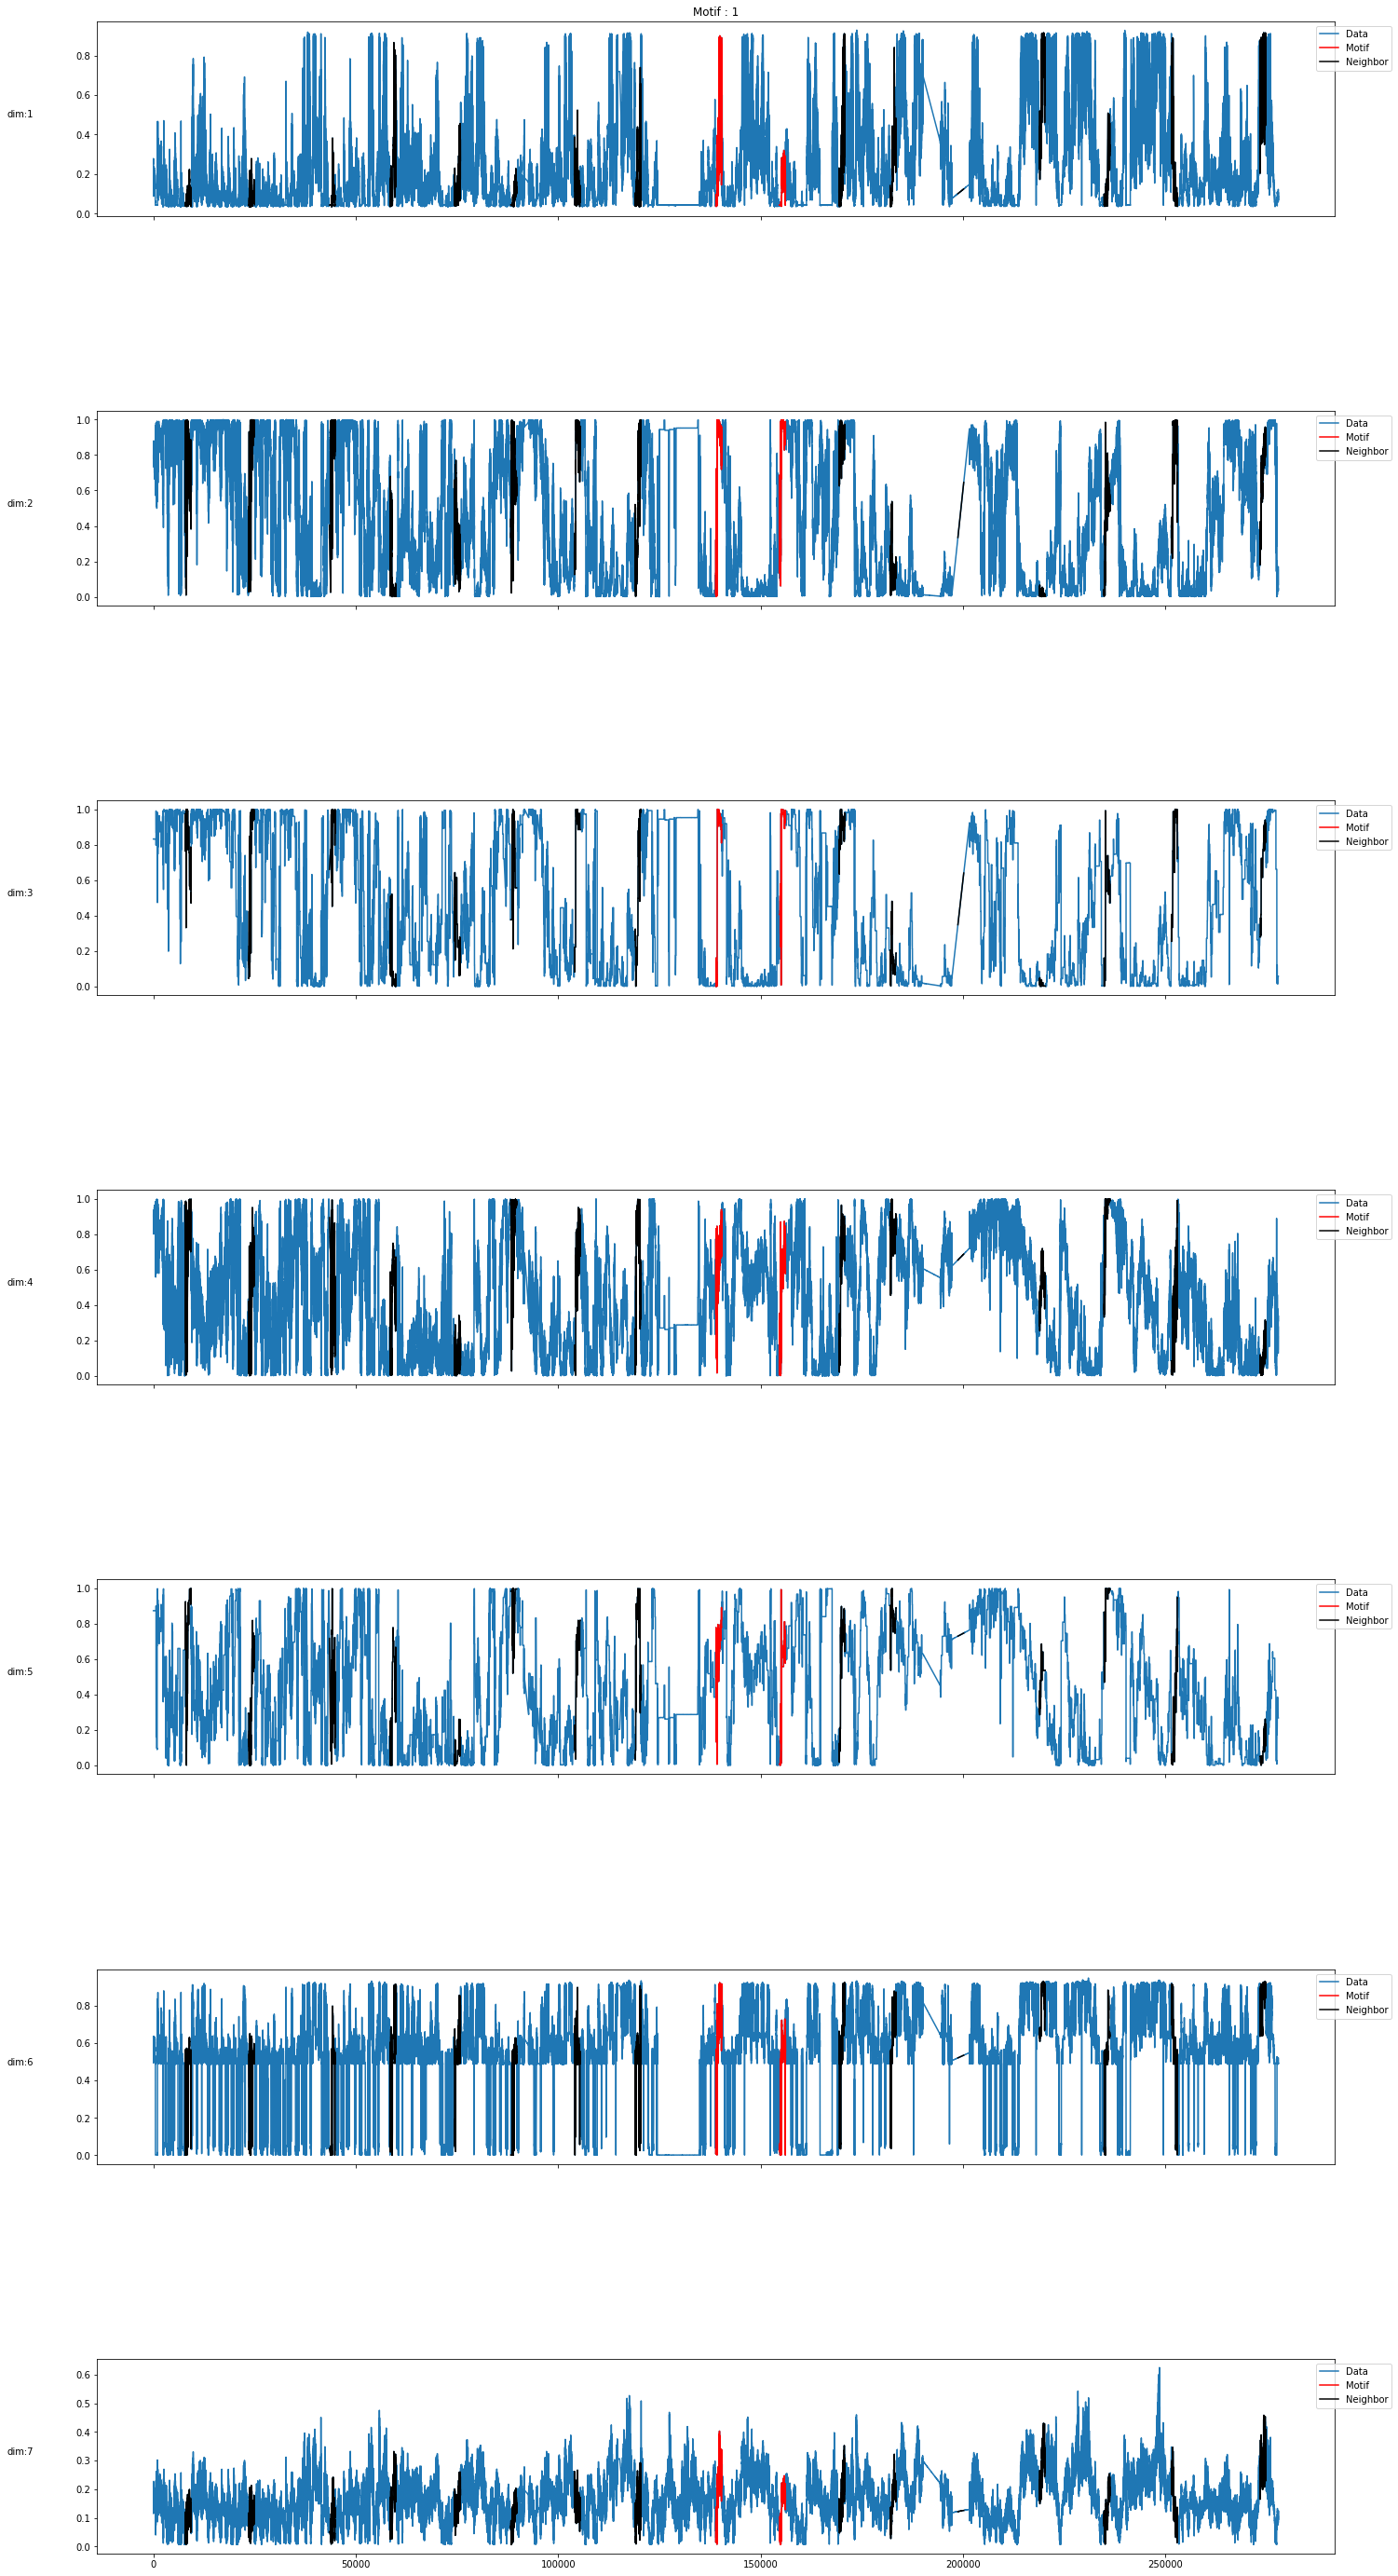

In [9]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    visualize_md(profile)

## Testing the generalization ability of the patterns
At this point, we are going to illustrate a method for testing if the found patterns can generalize well and if they can be useful in other similar timeseries.

In this specific example, we are going to load a dataset from another wind turbine and apply the same preprocessing steps as the ones we discussed in the beginning of this notebook before we continue.

In [10]:
dataset_file = '/data/data2/engie_initial/post_treated_data/BEZ/BEBEZE02_scada_high_frequency.parquet'
df2 = load_df(dataset_file)

# pick the most important columns
cols = ['wind speed', 'active power', 'rotor speed', 'pitch angle', 'sin_wind_dir', 'sin_nacelle_dir', 'cos_wind_dir', 'cos_nacelle_dir']
df2 = df2[cols]


# Scale each colimn of the dataframe to 0-1
df2 = scale_df(df2)

# Resample with a 60sec granularity
df2 = change_granularity(df2, granularity, chunk=False)

# Add a small amount of noise to the time series
df2 = add_noise_to_series_md(df2, noise_max = 0.00009)

# Keep a small subset of the dataset for demonstration purposes
start = '2018-07-02'
end = '2019-01-11'
df2 = filter_dates(df2, start, end)

df2 = df2[picked_cols] 

We are going to load the summary we have saved previously and sort the patterns we found based on their cost. Intuitively, low cost means that the majority of the occurances of the patterns is heavily observed in the one labeled region compared to the other. For example, consider the case of a pattern p that has 10 occurances, if the 10 occurances are in regions labeled x and 0 in regions labeled y then the cost will be 0 (the minimum), now if the occurances were 5 in regions labeled x and 5 in regions labeled y then its cost would be 1 (the maximum).

In [11]:
df_summary = pd.read_csv(summary_name)

# Drop motifs that majority == None
df_summary = df_summary.drop(df_summary[df_summary.iloc[:, -1] == 'None'].index)

# Drop motifs with cost == 0 (trivial matches)
df_summary = df_summary.drop(df_summary[df_summary['cost'] == 0].index)

# Drop motifs with less than 20 neighbors
df_summary = df_summary.drop(df_summary[(df_summary['aligned']  + df_summary['misaligned']) <= 20].index)

# Drop duplicate results for different experiment settings
df_summary = df_summary.drop_duplicates(subset=['motif indices'])

df_summary.sort_values(by='cost', inplace=True)
df_summary.reset_index(drop=True, inplace=True)
df_summary.head(30)

,k,motif_subseq_1,motif_subseq_2,aligned,misaligned,cost,window_size,exclusion_zone,radius,motif indices,majority of motif instance occurences
0,4,misaligned,misaligned,11,90,0.665358,1440,0.250,1.5,"[5692, 106079]",misaligned
1,5,misaligned,aligned,11,88,0.675373,1440,0.250,1.5,"[53792, 274596]",misaligned
2,4,misaligned,aligned,3,22,0.714826,1440,0.500,1.5,"[107932, 274225]",misaligned
3,1,misaligned,aligned,29,73,0.763250,1440,0.125,1.5,"[138948, 154717]",aligned
4,5,misaligned,aligned,28,71,0.766704,1440,0.125,1.5,"[221664, 259094]",aligned
5,8,misaligned,aligned,13,85,0.768342,1440,0.125,1.5,"[123808, 239618]",misaligned
6,6,misaligned,misaligned,12,76,0.783479,1440,0.250,1.5,"[39021, 182291]",misaligned
7,4,misaligned,misaligned,16,80,0.898542,1440,0.125,1.5,"[5134, 121421]",misaligned
8,9,misaligned,misaligned,17,85,0.898542,1440,0.125,1.5,"[19405, 87191]",misaligned
9,2,misaligned,misaligned,22,75,0.910552,1440,0.125,1.5,"[5324, 140379]",aligned


For the sake of this demonstration, we will pick at most five motif pairs we have previously extracted, on the other time series, with the lowest cost. Then, for each one of those patterns we are going to find its closest neighbors in the new time series and score them in the same manner as before. Also, we will check if the majority of the neighbors in the new time series lies in regions with the same label as in the time series it was originally extracted from. If the pattern in the new time series is assigned a low cost and the majority of its occurances are observed in regions of the same labels as before, then it is very likely that it generalizes in the new time series as well.

In [12]:
pairs = []
exclusion_zones = []
majorities = []
print(df_summary.shape)

# at most 5 of the lowest cost pairs
for i in range(0, min(5, df_summary.shape[0])):
    pairs.append(literal_eval(df_summary.loc[i, 'motif indices']))
    exclusion_zones.append(df_summary.loc[i, 'exclusion_zone'])
    majorities.append(df_summary.iloc[i, -1])

(15, 11)


In [13]:
# calculate the distances between the two segments of each motif pair
ts1 = df.values
ts2 = df2.values
pair_dists = []
for pair in pairs:
    indx1, indx2 = pair
    q = ts1[indx1:indx1+m] 
    t = ts1[indx2:indx2+m] 
    pdist = pairwise_dist(q, t)
    pair_dists.append(pdist)
    
# for each part of each motif pair find the closest neighbors and their distances
nn_list = []
nn_dists_list = []
for pair, dist, ez in zip(pairs, pair_dists, exclusion_zones):
    exclusion_zone = int(np.floor(m * ez))
    idx1, idx2 = pair
    q1 = ts1[idx1:idx1+m] 
    q2 = ts1[idx2:idx2+m]
    
    nn, nn_dists = find_neighbors(q1, ts2, m, exclusion_zone=exclusion_zone, min_dist=dist, max_neighbors=100)
    nn_list.append(nn)
    nn_dists_list.append(nn_dists)
    
    nn, nn_dists = find_neighbors(q2, ts2, m, exclusion_zone=exclusion_zone, min_dist=dist, max_neighbors=100)
    nn_list.append(nn)
    nn_dists_list.append(nn_dists)


In [14]:
def generate_output_row(q, nn_list, nn_dists_list, pair_dist, segment_labels, maj_other):
    if not nn_list == [] and not nn_dists_list ==[]:
        min_neighbor_dist = nn_i_dists[0]
        avg_neighbor_dist = np.mean(nn_i_dists)
        res_row = [q, pair_dist, min_neighbor_dist, avg_neighbor_dist]
        res = calculate_nn_stats(nn_i, mask, m, ez, segment_labels, maj_other)
        res_row.extend(res)
        return res_row
    return None

## Outputting the final results
Finally we create a csv file that contains the statistical results for the test we performed in the new time sereis for each pattern.

Note: The majority and the cost are calculated on normalized values of the occurances ("aligned"/"misaligned" in this case) based on the lengths of the segments.

In [15]:
result_rows = []
i = 0
# for each part of each motif pair calculate statistics and save
for q_idx_pair, maj, pair_dist, ez in zip(pairs, majorities, pair_dists, exclusion_zones):
    q_idx1, q_idx2 = q_idx_pair
    
    nn_i = nn_list[i]
    nn_i_dists = nn_dists_list[i]
    res_row = generate_output_row(q_idx1, nn_i, nn_i_dists, pair_dist, segment_labels, maj)
    if res_row is not None:
        result_rows.append(res_row)
    i+=1
    
    nn_i = nn_list[i]
    nn_i_dists = nn_dists_list[i]
    res_row = generate_output_row(q_idx2, nn_i, nn_i_dists, pair_dist, segment_labels, maj)
    if res_row is not None:
        result_rows.append(res_row)
    i+=1
    
output_name = 'test'
df_output = pd.DataFrame(result_rows, columns=['pattern_idx_in_ts1', 'motif_pair_dist_in_ts1', 
                                               f'Closest neighbor dist in ts2', 
                                               f'Average neighbor dist in ts2',
                                               f'NNs in ts2 indices', 
                                               'aligned', 'misaligned', 'exclusion_zone', 'cost',
                                               'matching_majority'])
df_output.head(20)

,pattern_idx_in_ts1,motif_pair_dist_in_ts1,Closest neighbor dist in ts2,Average neighbor dist in ts2,NNs in ts2 indices,aligned,misaligned,exclusion_zone,cost,matching_majority
0,5692,35.507103,23.779344,43.687443,"[5694, 25817, 50376, 140832, 45972, 20003, 905...",17,83,0.250,0.910338,True
1,106079,35.507103,24.319942,40.281058,"[106080, 140757, 172445, 267441, 5729, 90651, ...",14,86,0.250,0.798079,True
2,53792,30.309882,23.444631,37.259219,"[223135, 84803, 42200, 185618, 251638, 118187,...",21,77,0.250,0.946781,False
3,274596,30.309882,23.487580,40.869240,"[274596, 84762, 185562, 173863, 185970, 180203...",21,78,0.250,0.953217,False
4,107932,32.952193,24.799772,39.650375,"[107934, 185366, 173660, 53559, 118086, 222832...",18,80,0.500,0.957109,True
5,274225,32.952193,27.076560,42.748928,"[274225, 173655, 185542, 121119, 193607, 17983...",18,79,0.500,0.963389,True
6,138948,24.172781,23.872267,37.887421,"[138949, 169413, 126637, 234881, 169220, 21889...",18,82,0.125,0.944793,False
7,154717,24.172781,24.915515,36.842479,"[169414, 218805, 136010, 126614, 169233, 24247...",19,81,0.125,0.977909,False
8,221664,34.567569,25.128519,41.362740,"[221665, 259124, 250562, 272432, 263187, 64534...",21,78,0.125,0.953217,True
9,259094,34.567569,18.368607,37.921793,"[259093, 259274, 272639, 272445, 263264, 25052...",31,69,0.125,0.706081,True
